In [105]:
# imports
import sys 
import os
import random
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors 
import matplotlib.cbook as cbook 
plt.rcParams.update({'font.size': 12}) 
import mpld3 
import ast
#import ROOT
import uproot3 as ur3
import uproot as ur4
import pandas as pd 
from tqdm import tqdm 
from scipy.optimize import curve_fit 
from scipy import stats
from scipy.signal import lfilter, filtfilt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.integrate import quad
from scipy import interpolate, optimize
import scipy.integrate as integrate
from lmfit import Model
import threading
from pathlib import Path
from matplotlib import gridspec
import datetime
import matplotlib.ticker as mticker
import time
import pathlib
import awkward as ak
import pprint
import pickle
import struct
from os.path import exists

In [106]:
global AllData
AllData = {}

global ColorBook
ColorBook = {
                "Main Fit" : "magenta",
                "Data" : "blue",
                "Add-Ons" : "slategrey",
                0 : "forestgreen",
                1 : "darkorange",
                2 : "peru",
                3 : "greenyellow"
            }

In [107]:
def GetBranchFromTree(myFile,treename,branchname):
    nparray = np.array(myFile[treename][branchname].array())
        
    return nparray

def gauss(x, amp, mu, sigma):
    return amp*np.exp(-((x-mu)**2)/(2*(sigma**2)))

def sigmoid(t, x0, s, a):
    y = 1.0 / (1.0 + np.exp((x0 - t) / s))
    return a * y

def find_50(x_samples,y_samples,mean):
    fifty_percent_level = 0.5*np.min(y_samples)*np.ones_like(x_samples)

    interp_fn = interpolate.interp1d(x_samples, y_samples, 'linear')
    interp_fn2 = lambda x: interp_fn(x)-(0.5*np.min(y_samples))

    root1 = optimize.newton(interp_fn2, mean)
    
    # plt.plot(x_samples,y_samples,'kx')
    # plt.plot(x_samples,fifty_percent_level,'b-')
    # plt.plot(x_samples, interp_fn2(x_samples), 'g--', label='interp_fn2')
    # plt.axvline(x=root1)

    return root1


In [108]:
file_path = "../Data/Jitter/"
if os.path.exists(file_path+"Backup.pickle"):
    with open(file_path+"Backup.pickle", 'rb') as file:
        AllData = pickle.load(file)
else:
    filename = file_path+"RawData.root"
    myFile = ur4.open(filename)
    branchname_data = "Data_ch0"
    branchname_trigger = "Trigger_data_g0"

    for i_event in tqdm(range(1,60304), desc='Loading data'):
        data = GetBranchFromTree(myFile,"Event{};1".format(i_event),branchname_data)[0][30:999]
        data = data - np.mean(data[800:900])
        trigger = GetBranchFromTree(myFile,"Event{};1".format(i_event),branchname_trigger)[0][30:999]
        trigger = trigger - np.mean(trigger[0:100])

        if i_event not in AllData:
            AllData.update({i_event: {"data" : data, "trigger": trigger}})
        else:
            AllData[i_event] = {"data" : data, "trigger": trigger}

    myFile.close()

    with open(file_path+"Backup.pickle", 'wb') as file:
        pickle.dump(AllData, file)

Loading data: 100%|█████████▉| 60302/60303 [39:02<00:00, 25.74it/s]


KeyInFileError: not found: 'Event60303' with cycle 1

    Available keys: 'Event6003;1', 'Event6030;1', 'Event6033;1', 'Event600;1', 'Event603;1', 'Event60003;1', 'Event60013;1', 'Event60023;1', 'Event60030;1', 'Event60031;1', 'Event60032;1', 'Event60033;1', 'Event60034;1', 'Event60035;1'...

in file ../Data/Jitter/RawData.root

In [ ]:
for eventID, data_and_trigger in tqdm(AllData.items(),desc='Building Array'): 
    data = data_and_trigger["data"]
    trigger = data_and_trigger["trigger"]
    x_values = np.array(range(len(data)))/5

    fig = plt.figure(figsize=[10,10], facecolor='white')
    plt.plot(x_values,data,'x')
    popt, pcov = curve_fit(gauss, xdata=x_values, ydata=data, p0=[np.min(data),x_values[np.where(data==np.max(data))[0][0]],5])
    plt.plot(x_values,gauss(x_values,*popt),'-r')
    t1 = popt[1] + np.sqrt(-2 * popt[2]**2 * np.log(0.5*np.min(data)/popt[0]))
    t2 = popt[1] - np.sqrt(-2 * popt[2]**2 * np.log(0.5*np.min(data)/popt[0]))
    ChannelThresholdChannel = t2
    print(t1,t2)
    plt.axvline(x=ChannelThresholdChannel,c='k')
    plt.xlim(50,75)
    plt.ylim(-20,5)
    plt.show()

    fig = plt.figure(figsize=[10,10], facecolor='white')
    plt.plot(x_values,trigger,'x')
    popt, pcov = curve_fit(sigmoid, xdata=x_values[np.where(trigger==np.max(trigger))[0][0]-50:50+np.where(trigger==np.max(trigger))[0][0]], ydata=trigger[np.where(trigger==np.max(trigger))[0][0]-50:50+np.where(trigger==np.max(trigger))[0][0]], p0=[x_values[np.where(trigger==np.max(trigger))[0][0]],3,np.min(trigger)])
    plt.plot(x_values,sigmoid(x_values,*popt),'-r')
    print(popt[0]-popt[1]*np.log(popt[2]/(0.5*np.min(trigger))-1),)
    plt.axvline(x=popt[0]-popt[1]*np.log(popt[2]/(0.5*np.min(trigger))-1),c='k')
    plt.xlim(109,118)
    plt.show()

In [109]:
dt_array = []
for eventID, data_and_trigger in tqdm(AllData.items(),desc='Building Array'): 
    data = data_and_trigger["data"]
    trigger = data_and_trigger["trigger"]
    x_values = np.array(range(len(data)))/5

    if np.fabs(np.min(data)-np.max(data))<500 or np.fabs(np.min(trigger)-np.max(trigger))<500:
        continue

    indices_data = np.where((data < 0.40 * np.min(data)) & (data > 0.60 * np.min(data)))
    first_index_data = indices_data[0][0]
    first_index_data /= 5

    indices_trigger = np.where((trigger < 0.40 * np.min(trigger)) & (trigger > 0.60 * np.min(trigger)))
    first_index_trigger = indices_trigger[0][0]
    first_index_trigger /= 5

    x_data = find_50(x_values, data, first_index_data)
    x_trigger = find_50(x_values, trigger, first_index_trigger)

    dt = x_trigger - x_data
    dt_array.append(dt)

Building Array: 100%|██████████| 60302/60302 [00:56<00:00, 1058.71it/s]


[1716, 40.15, 2]
[1.56851544e+03 4.01895924e+01 3.01604169e-01]


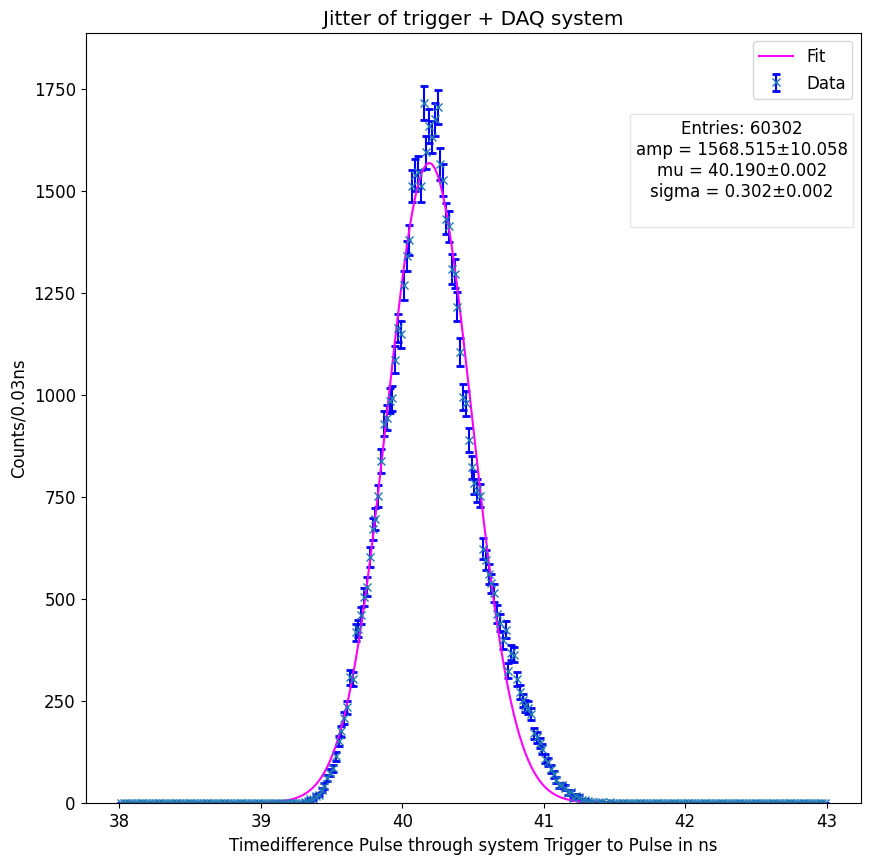

In [110]:
hist_data ,bin_edges = np.histogram(dt_array,bins=250,range=(38,43))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

initial_parameters = [np.max(hist_data),bin_centers[np.where(hist_data==np.max(hist_data))[0][0]],2]
print(initial_parameters)

popt, pcov = curve_fit(gauss,xdata=bin_centers,ydata=hist_data,p0=initial_parameters,method='lm')
print(popt)

fig = plt.figure(figsize=[10,10], facecolor='white')
x_fit = np.linspace(38, 43, len(bin_centers))
y_fit = gauss(x_fit, *popt)

## Draw the histogram and the main fit
plt.errorbar(bin_centers, hist_data, yerr=np.sqrt(hist_data), fmt='x', capsize=3, capthick=2, ecolor=ColorBook["Data"] ,label="Data")
plt.plot(bin_centers, y_fit, c=ColorBook["Main Fit"], ls='-', label="Fit")
plt.title("Jitter of trigger + DAQ system")


legend_labels = 'Entries: {}\namp = {:.3f}±{:.3f}\nmu = {:.3f}±{:.3f}\nsigma = {:.3f}±{:.3f}\n'.format(len(dt_array),popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1])
                                                                                                       ,popt[2],np.sqrt(pcov[2,2]))

## Plotsettings
plt.xlabel("Timedifference Pulse through system Trigger to Pulse in ns")
plt.ylabel("Counts/{:.2f}ns".format((43-38)/200))
plt.ylim(0,1.1*np.max(hist_data))
plt.legend()
plt.text(42.4, 1550, legend_labels, fontsize=12, color='black', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.1))
plt.show()
